## Nom et Prenom : KABLANI Iliasse


## 0) Imports et configuration 


In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



## 1) Chargement du dataset (sklearn) et encodage binaire M/B → 1/0
- `load_breast_cancer()` retourne des étiquettes : 0 = *malignant* (malin), 1 = *benign* (bénin).  
- On veut : **malin = 1**, **bénin = 0**.


In [4]:

data = load_breast_cancer()
X_all = data.data
y_raw = data.target  # 0=malignant, 1=benign

# Conversion: malignant(0) -> 1 ; benign(1) -> 0, sans if/else (opération vectorisée)
y_all = np.where(y_raw == 0, 1, 0).astype(np.int64)

feature_names = list(data.feature_names)

X_all.shape, np.bincount(y_all)


((569, 30), array([357, 212]))


## 2) Split train/validation/test (60/20/20), standardisation, tensors + DataLoaders


In [5]:

X_train, X_tmp, y_train, y_tmp = train_test_split(
    X_all, y_all, test_size=0.4, random_state=42, stratify=y_all
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, random_state=42, stratify=y_tmp
)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_val_std   = scaler.transform(X_val)
X_test_std  = scaler.transform(X_test)

X_train_t = torch.tensor(X_train_std, dtype=torch.float32)
y_train_t = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_val_t   = torch.tensor(X_val_std, dtype=torch.float32)
y_val_t   = torch.tensor(y_val.reshape(-1, 1), dtype=torch.float32)
X_test_t  = torch.tensor(X_test_std, dtype=torch.float32)
y_test_t  = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t, y_val_t)
test_ds  = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=128, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=128, shuffle=False)

X_train_t.shape, y_train_t.shape, X_val_t.shape, X_test_t.shape


(torch.Size([341, 30]),
 torch.Size([341, 1]),
 torch.Size([114, 30]),
 torch.Size([114, 30]))


## 3) Modèle `nn.Sequential` (3 couches) + Dropout + ReLU + Sigmoid
> Aucune classe personnalisée : on instancie directement une séquence.


In [6]:

in_features = X_train_t.shape[1]

model = nn.Sequential(
    nn.Linear(in_features, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(32, 1),
    nn.Sigmoid()
)

model = model.to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # L2 via weight_decay



## 4) Entraînement linéaire (époques fixes), sans early stopping ni checkpoint
On trace aussi les pertes **train** et **validation** à chaque époque.


In [7]:

EPOCHS = 100

train_losses = []
val_losses = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    s = 0.0
    n = 0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        s += loss.item() * xb.size(0)
        n += xb.size(0)
    train_loss = s / n
    train_losses.append(train_loss)

    model.eval()
    s_val = 0.0
    n_val = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            s_val += loss.item() * xb.size(0)
            n_val += xb.size(0)
    val_loss = s_val / n_val
    val_losses.append(val_loss)

    print(f"Epoch {epoch:03d}  train_loss={train_loss:.4f}  val_loss={val_loss:.4f}")


Epoch 001  train_loss=0.6847  val_loss=0.6201
Epoch 002  train_loss=0.5971  val_loss=0.5222
Epoch 003  train_loss=0.5049  val_loss=0.4072
Epoch 004  train_loss=0.3888  val_loss=0.2858
Epoch 005  train_loss=0.2850  val_loss=0.1848
Epoch 006  train_loss=0.1969  val_loss=0.1228
Epoch 007  train_loss=0.1560  val_loss=0.0924
Epoch 008  train_loss=0.1288  val_loss=0.0768
Epoch 009  train_loss=0.1082  val_loss=0.0676
Epoch 010  train_loss=0.0955  val_loss=0.0595
Epoch 011  train_loss=0.0899  val_loss=0.0538
Epoch 012  train_loss=0.0795  val_loss=0.0489
Epoch 013  train_loss=0.0822  val_loss=0.0473
Epoch 014  train_loss=0.0708  val_loss=0.0461
Epoch 015  train_loss=0.0791  val_loss=0.0451
Epoch 016  train_loss=0.0717  val_loss=0.0452
Epoch 017  train_loss=0.0662  val_loss=0.0451
Epoch 018  train_loss=0.0628  val_loss=0.0439
Epoch 019  train_loss=0.0574  val_loss=0.0458
Epoch 020  train_loss=0.0555  val_loss=0.0473
Epoch 021  train_loss=0.0546  val_loss=0.0479
Epoch 022  train_loss=0.0551  val_


## 5) Courbes des pertes


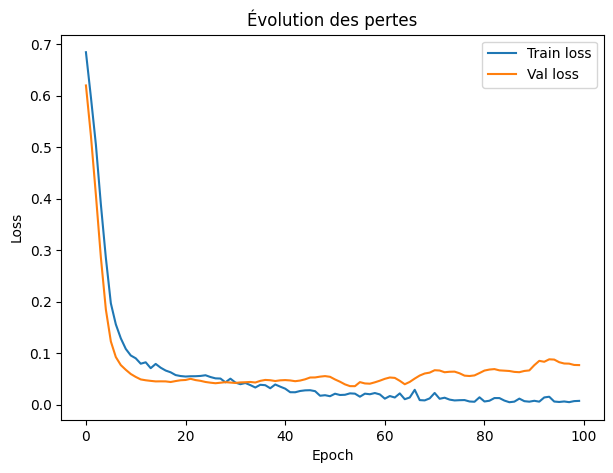

In [8]:

plt.figure(figsize=(7,5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Évolution des pertes")
plt.legend()
plt.show()



## 6) Évaluation sur le test set (Accuracy, Precision, Recall, F1)
Seuil de décision : 0.5.


In [9]:

model.eval()
y_true = []
y_prob = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        preds = model(xb)
        y_true.extend(yb.cpu().numpy().ravel().tolist())
        y_prob.extend(preds.cpu().numpy().ravel().tolist())

y_pred = (np.array(y_prob) >= 0.5).astype(int)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

print("\nClassification report:\n")
print(classification_report(y_true, y_pred, digits=4))


Accuracy : 0.9737
Precision: 1.0000
Recall   : 0.9286
F1-score : 0.9630

Classification report:

              precision    recall  f1-score   support

         0.0     0.9600    1.0000    0.9796        72
         1.0     1.0000    0.9286    0.9630        42

    accuracy                         0.9737       114
   macro avg     0.9800    0.9643    0.9713       114
weighted avg     0.9747    0.9737    0.9735       114





## Étape 1: Chargement du dataset

**Q1: Pourquoi ce dataset est-il adapté à une classification binaire ?**
- Le dataset Breast Cancer Wisconsin contient des caractéristiques de tumeurs classées comme **Malignes (M)** ou **Bénignes (B)**.
- Il s'agit d'un problème de classification à deux classes distinctes et mutuellement exclusives.
- L'objectif est de prédire si une tumeur est maligne (cancer) ou bénigne (non-cancéreuse), ce qui est parfait pour une classification binaire.

**Q2: Pourquoi faut-il encoder les valeurs M/B en 1/0 ?**
- Les modèles d'apprentissage automatique fonctionnent avec des données numériques uniquement.
- L'encodage M→1, B→0 (ou l'inverse) convertit les étiquettes catégorielles en format numérique.
- Cela permet au modèle de calculer des gradients et d'optimiser les paramètres.
- La fonction de perte BCELoss attend des valeurs numériques (0 ou 1).

## Étape 2: Préparation des données

**Q1: Pourquoi standardise-t-on les données ?**
- **Convergence plus rapide** : Les algorithmes d'optimisation convergent plus rapidement avec des données normalisées.
- **Évite la domination d'échelle** : Sans standardisation, les caractéristiques avec de grandes valeurs dominent l'apprentissage.
- **Stabilité numérique** : Améliore la stabilité des calculs, surtout pour les réseaux de neurones.
- **Initialisation des poids** : Rend l'initialisation des poids plus efficace.

**Q2: Pourquoi séparer en validation et non juste train/test ?**
- **Train set** : Pour entraîner le modèle.
- **Validation set** : Pour ajuster les hyperparamètres et détecter l'overfitting pendant l'entraînement.
- **Test set** : Pour l'évaluation finale uniquement (ne jamais l'utiliser pour le réglage).
- Sans validation, on ne peut pas surveiller les performances pendant l'entraînement ni implémenter l'early stopping.

**Q3: Quel est l'intérêt de stratifier les splits ?**
- **Préserve les proportions** : Chaque sous-ensemble garde la même proportion de classes que le dataset original.
- **Évite le biais** : Empêche qu'un split contienne très peu d'échantillons d'une classe.
- **Crucial pour les classes déséquilibrées** : Assure une représentation équitable de chaque classe.

## Étape 3: Définition du modèle

**Q1: Quel est l'effet du Dropout sur l'entraînement ?**
- **Réduit l'overfitting** : Force le réseau à ne pas dépendre de neurones spécifiques.
- **Améliore la généralisation** : Crée un effet d'ensemble en entraînant plusieurs sous-réseaux.
- **Ralentit la convergence** : Nécessite plus d'époques car le réseau change constamment.
- **Régularisation** : Empêche la mémorisation par cœur des données d'entraînement.

**Q2: Essayez avec différents taux (0%, 30%, 50%). Que remarquez-vous ?**
- **0% Dropout** : Aucune régularisation, risque élevé d'overfitting.
- **30% Dropout** : Bon équilibre entre apprentissage et régularisation.
- **50% Dropout** : Forte régularisation, peut causer du sous-apprentissage si trop élevé.
- **Observation** : L'écart entre train/validation loss diminue avec un dropout approprié.

**Q3: Pourquoi utilise-t-on ReLU dans les couches cachées ? Et Sigmoïde en sortie ?**
- **ReLU dans les couches cachées** :
  - **Non-linéarité** : Permet d'apprendre des patterns complexes.
  - **Efficacité** : Calcul rapide (max(0,x)).
  - **Gradients** : Évite le problème des gradients évanescents.
  - **Sparsité** : Peut créer des activations éparses.
- **Sigmoïde en sortie** :
  - **Probabilité** : Sortie entre 0 et 1, interprétable comme probabilité.
  - **Classification binaire** : Parfait pour les problèmes à deux classes.
  - **Différentiable** : Compatible avec BCELoss.

## Étape 4: Fonction de perte, optimiseur, EarlyStopping

**Q1: Pourquoi surveiller la perte sur validation ?**
- **Détection d'overfitting** : Quand train loss diminue mais val loss augmente.
- **Estimation non biaisée** : Performance sur données non vues.
- **Arrêt optimal** : Permet d'arrêter l'entraînement au bon moment.

**Q2: Que se passe-t-il si on continue à entraîner après overfitting ?**
- **Mémorisation** : Le modèle mémorise les données d'entraînement.
- **Dégradation** : Performance sur nouvelles données se dégrade.
- **Perte de généralisation** : Le modèle devient trop spécialisé.

**Q3: Dans quels cas early stopping est-il crucial ?**
- **Petits datasets** : Risque élevé d'overfitting.
- **Modèles complexes** : Beaucoup de paramètres.
- **Coût élevé** : Entraînement coûteux en temps/ressources.
- **Applications critiques** : Médical, sécurité, etc.

## Étape 5: Entraînement avec sauvegarde du meilleur modèle

**Q1: Pourquoi sauvegarder les meilleurs poids et non les derniers ?**
- **Évite l'overfitting** : Les derniers poids peuvent être sur-entraînés.
- **Point optimal** : Les meilleurs poids représentent le meilleur équilibre.
- **Performance garantie** : Assure les meilleures performances sur données non vues.

**Q2: Quelle est l'alternative à ModelCheckpoint dans un contexte non PyTorch ?**
- **TensorFlow/Keras** : `ModelCheckpoint` callback avec `save_best_only=True`.
- **Scikit-learn** : `joblib.dump()` ou `pickle` pour sauvegarder manuellement.
- **Autres frameworks** : Implémentation manuelle basée sur les métriques de validation.

## Étape 6: Évaluation du modèle

**Q1: Quelle est la différence entre accuracy et F1 ?**
- **Accuracy** : Proportion de prédictions correctes. Peut être trompeuse avec classes déséquilibrées.
- **F1-score** : Moyenne harmonique de précision et rappel. Plus robuste avec classes déséquilibrées.

**Q2: Dans quels cas le recall est-il prioritaire ?**
- **Détection de maladies** : Mieux vaut des faux positifs que rater un vrai cas.
- **Détection de fraudes** : Crucial de détecter toutes les fraudes.
- **Sécurité** : Détection d'intrusions, anomalies critiques.

**Q3: Quel score serait le plus critique dans un contexte médical ?**
- **Le recall (sensibilité)** est le plus critique en médecine.
- **Cancer du sein** : Il est crucial de ne rater aucun cas de cancer.
- **Faux négatif = danger mortel** : Un faux positif peut être vérifié, mais un faux négatif peut être fatal.